<a href="https://colab.research.google.com/github/amun83/Koscom-FinancialDataCamp/blob/master/FD103_Forecasting_Natural_Gas_ETN_Prices_ARIMA_vs_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
ON_COLAB = True
DATA_PATH = ''
!python --version

Python 3.6.7


In [0]:
!pip install -q --upgrade pystan
!pip install -q --upgrade fbprophet
!pip install -q --upgrade tensorflow
!pip install -q --upgrade keras
#!pip install -q --upgrade pandas_datareader
#!pip install -q --upgrade finance-datareader
#!pip install -q --upgrade html5lib
#!pip install -q --upgrade lxml
!pip install -q --upgrade seaborn
!pip install -q --upgrade gspread

In [2]:
# utilities
import datetime
import re
from IPython.display import display

# web scraping
#import requests
#import urllib.parse
#from bs4 import BeautifulSoup
#import pandas_datareader as pdr
#import FinanceDataReader as fdr

# Math/Stat
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import math
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# Machine Learning
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# visualization
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

sns.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


'0.9.0'

## Summary
* EDA
* ARIMA : Facebook Prophet
* Deep Learning : Keras

## 데이터 준비 I

In [3]:
if ON_COLAB :
  from google.colab import drive
  drive.mount('/gdrive')
  DATA_PATH = '/gdrive/My Drive/Natural Gas Data/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
# Dow Jones Commodity Index Natural Gas TR
with open(DATA_PATH + 'DJCI.csv', 'r') as f:
  df_DJCI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_DJCI.head(3), df_DJCI.tail(3))

,Dow Jones Commodity Index Natural Gas TR,Dow Jones Commodity Index Natural Gas ER,Dow Jones Commodity Index Natural Gas
Effective date,,,
2018-11-16,0.85,0.60,233.33
2018-11-15,0.80,0.56,219.85
2018-11-14,0.97,0.68,266.34


,Dow Jones Commodity Index Natural Gas TR,Dow Jones Commodity Index Natural Gas ER,Dow Jones Commodity Index Natural Gas
Effective date,,,
2008-11-04,21.64,15.70,392.55
2008-11-03,20.50,14.87,371.83
2008-10-31,20.33,14.75,368.84


In [5]:
# Henry Hub Natural Gas Spot
with open(DATA_PATH + 'NG_Spot.csv', 'r') as f:
  df_Spot = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_Spot.head(3), df_Spot.tail(3))

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61


,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
2018-11-09,3.74
2018-11-12,3.96
2018-11-13,4.10


In [6]:
# NYMEX Natural Gas Futures
with open(DATA_PATH + 'NG_Futures.csv', 'r') as f:
  df_Futures = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_Futures.head(3), df_Futures.tail(3))

,Natural Gas Futures Contract 1 (Dollars per Million Btu),Natural Gas Futures Contract 2 (Dollars per Million Btu),Natural Gas Futures Contract 3 (Dollars per Million Btu),Natural Gas Futures Contract 4 (Dollars per Million Btu)
Date,,,,
1993-12-20,NaN,NaN,NaN,1.894
1993-12-21,NaN,NaN,NaN,1.830
1993-12-22,NaN,NaN,NaN,1.859


,Natural Gas Futures Contract 1 (Dollars per Million Btu),Natural Gas Futures Contract 2 (Dollars per Million Btu),Natural Gas Futures Contract 3 (Dollars per Million Btu),Natural Gas Futures Contract 4 (Dollars per Million Btu)
Date,,,,
2018-11-12,3.788,3.800,3.660,3.293
2018-11-13,4.101,4.147,4.019,3.712
2018-11-14,4.837,4.898,4.770,4.472


In [7]:
# EIA Weekly Natural Gas Storage Report
with open(DATA_PATH + 'NG_Storage.csv', 'r') as f:
  df_Storage = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_Storage.head(3), df_Storage.tail(3))

,Source,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
Week ending,,,,,,,,,
2010-01-01,Derived EIA Weekly Estimates,769,900,195,268,985,159,826,3117
2010-01-08,Derived EIA Weekly Estimates,703,820,185,257,886,123,763,2850
2010-01-15,Derived EIA Weekly Estimates,642,750,176,246,793,91,702,2607


,Source,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
Week ending,,,,,,,,,
2018-10-26,EIA-912,826,956,180,262,919,234,686,3143
2018-11-02,EIA-912,831,980,182,265,949,253,696,3208
2018-11-09,EIA-912,835,991,181,266,974,272,702,3247


In [8]:
# EIA Monthly Gross Withdrawals and Production
with open(DATA_PATH + 'Production.csv', 'r') as f:
  df_Production = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_Production.head(3), df_Production.tail(3))

,U.S. Natural Gas Gross Withdrawals (MMcf),U.S. Natural Gas Gross Withdrawals from Gas Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Oil Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Shale Gas (Million Cubic Feet),U.S. Natural Gas Gross Withdrawals from Coalbed Wells (MMcf),U.S. Natural Gas Repressuring (MMcf),U.S. Natural Gas Vented and Flared (MMcf),U.S. Nonhydrocarbon Gases Removed from Natural Gas (MMcf),U.S. Natural Gas Marketed Production (MMcf),U.S. Natural Gas Plant Liquids Production (Million Cubic Feet),U.S. Dry Natural Gas Production (MMcf),Unnamed: 12
Date,,,,,,,,,,,,
1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948000,79000,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962000,79000,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1907000,77000,NaN,NaN


,U.S. Natural Gas Gross Withdrawals (MMcf),U.S. Natural Gas Gross Withdrawals from Gas Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Oil Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Shale Gas (Million Cubic Feet),U.S. Natural Gas Gross Withdrawals from Coalbed Wells (MMcf),U.S. Natural Gas Repressuring (MMcf),U.S. Natural Gas Vented and Flared (MMcf),U.S. Nonhydrocarbon Gases Removed from Natural Gas (MMcf),U.S. Natural Gas Marketed Production (MMcf),U.S. Natural Gas Plant Liquids Production (Million Cubic Feet),U.S. Dry Natural Gas Production (MMcf),Unnamed: 12
Date,,,,,,,,,,,,
2018-06-01,2954943.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2641008,187394,2453614.0,NaN
2018-07-01,3106695.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2782326,197213,2585113.0,NaN
2018-08-01,3178843.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2843746,203516,2640230.0,NaN


In [9]:
# US Temperature
with open(DATA_PATH + 'Temperature.csv', 'r') as f:
  df_Temperature = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_Temperature.head(3), df_Temperature.tail(3))

,Avg,Min,Max
Date,,,
2018-11-19,15.82,11.43,20.20
2018-11-18,15.48,11.03,19.93
2018-11-17,15.91,11.38,20.44


,Avg,Min,Max
Date,,,
2013-11-29,14.48,9.06,19.90
2013-11-28,13.96,8.75,19.17
2013-11-27,14.47,9.53,19.40


In [10]:
# NOAA Arctic Oscillation Index
with open(DATA_PATH + 'AO_Index.csv', 'r') as f:
  df_AOI = pd.read_csv(f, header = None, index_col = 0, parse_dates = [[0, 1, 2]])
  display(df_AOI.head(3), df_AOI.tail(3)) 

,3
0_1_2,
1979-01-01,-1.556
1979-01-02,-0.888
1979-01-03,0.255


,3
0_1_2,
2018-10-29,0.508
2018-10-30,0.754
2018-10-31,0.776


In [11]:
# Crude Oil WTI Futures
with open(DATA_PATH + 'WTI_Futures.csv', 'r') as f:
  df_WTI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_WTI.head(3), df_WTI.tail(3))

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,56.98,57.31,57.55,56.83,-,-0.56%
2018-11-18,57.30,57.00,57.36,56.93,-,1.49%
2018-11-16,56.46,56.58,57.96,55.89,159.00K,0.00%


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1990-01-04,23.41,23.90,23.92,22.83,53.07K,-1.14%
1990-01-03,23.68,23.19,23.80,23.00,50.06K,3.45%
1990-01-02,22.89,21.81,22.92,21.79,45.18K,4.90%


In [12]:
# US Dollar Index
with open(DATA_PATH + 'Dollar_Index.csv', 'r') as f:
  df_DI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_DI.head(3), df_DI.tail(3))

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,96.36,96.45,96.57,96.32,-,-0.07%
2018-11-18,96.43,96.43,96.45,96.38,-,-0.04%
2018-11-16,96.47,97.05,97.06,96.40,-,-0.47%


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1990-01-03,94.42,94.15,94.52,94.08,-,0.14%
1990-01-02,94.29,93.13,94.31,93.08,-,1.16%
1990-01-01,93.21,93.19,93.31,93.08,-,0.00%


## 데이터 준비 II : CFTC  Non-Commercial  Net Positions
* https://colab.research.google.com/drive/1YvdML1V_0VCqwkPCny528AIPjCZUbIYw

In [13]:
# CFTC Weekly Non-Commercial Net Positions = COTDLC (M)
with open(DATA_PATH + 'CFTC.csv', 'r') as f:
  df_CFTC = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(df_CFTC.head(3), df_CFTC.tail(3))

,COTDLC (M),COTDLC (O),COTDLC (P),COTDLC (S),COTLC (C),COTLC (L),COTLC (S),Interest,Volume,close,high,low,open,symbol
date,,,,,,,,,,,,,,
2018-11-21,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,NaN,5,5,5,5,NGZ18
2018-11-20,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,697315.0,5,5,4,5,NGZ18
2018-11-19,279113,-256767,-50347,-9794,-60141,22346,37795,1381403.0,805724.0,5,5,4,5,NGZ18


,COTDLC (M),COTDLC (O),COTDLC (P),COTDLC (S),COTLC (C),COTLC (L),COTLC (S),Interest,Volume,close,high,low,open,symbol
date,,,,,,,,,,,,,,
2012-11-05,36281,-85285,-40316,48164,7848,-49004,41156,1175941.0,217603.0,4,4,4,4,NGZ12
2012-11-02,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,290111.0,4,4,4,4,NGZ12
2012-11-01,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,272918.0,4,4,4,4,NGZ12


## 데이터 통합

In [14]:
M = pd.concat([ df_DJCI['Dow Jones Commodity Index Natural Gas TR'],
                df_Spot,
                df_Futures['Natural Gas Futures Contract 1 (Dollars per Million Btu)'],
                df_Storage['Total Lower 48'],
                df_Production['U.S. Natural Gas Gross Withdrawals (MMcf)'],
                df_Temperature['Avg'],
                df_AOI,
                df_WTI['Price'],
                df_DI['Price'],
                df_CFTC['COTDLC (M)'] ], axis = 1)

M.columns = ['DJCI', 'Spot', 'Futures', 'Storage', 'Production', 'Temperature', 'AOI', 'WTI', 'DI', 'CFTC']
M.index.name = 'Date'

M.tail(10)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
Date,,,,,,,,,,
2018-11-12,0.76,3.96,3.788,NaN,NaN,16.20,NaN,59.93,97.54,245106.0
2018-11-13,0.82,4.10,4.101,NaN,NaN,15.82,NaN,55.69,97.30,279113.0
2018-11-14,0.97,NaN,4.837,NaN,NaN,15.25,NaN,56.25,96.80,279113.0
2018-11-15,0.80,NaN,NaN,NaN,NaN,15.45,NaN,56.46,96.93,279113.0
2018-11-16,0.85,NaN,NaN,NaN,NaN,15.79,NaN,56.46,96.47,279113.0
2018-11-17,NaN,NaN,NaN,NaN,NaN,15.91,NaN,NaN,NaN,NaN
2018-11-18,NaN,NaN,NaN,NaN,NaN,15.48,NaN,57.30,96.43,NaN
2018-11-19,NaN,NaN,NaN,NaN,NaN,15.82,NaN,56.98,96.36,279113.0
2018-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279113.0


In [15]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14642 entries, 1973-01-01 to 2018-11-21
Data columns (total 10 columns):
DJCI           2532 non-null float64
Spot           5500 non-null float64
Futures        6230 non-null float64
Storage        463 non-null float64
Production     464 non-null float64
Temperature    1819 non-null float64
AOI            14548 non-null float64
WTI            7312 non-null float64
DI             7486 non-null float64
CFTC           1526 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


## 결측치 처리

In [16]:
M.isnull().sum()

DJCI           12110
Spot            9142
Futures         8412
Storage        14179
Production     14178
Temperature    12823
AOI               94
WTI             7330
DI              7156
CFTC           13116
dtype: int64

In [17]:
M['Production'] = M['Production'].apply(lambda x : x / 30)

M.fillna(method = 'ffill', inplace = True)
M.dropna(inplace = True)

display(M.head(3), M.tail(3))

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
Date,,,,,,,,,,
2013-11-27,1.81,3.87,3.895,3775.0,81838.966667,14.47,-0.050,92.30,80.72,-17803.0
2013-11-28,1.81,3.87,3.895,3775.0,81838.966667,13.96,-0.399,92.28,80.72,-17803.0
2013-11-29,1.84,3.87,3.954,3613.0,81838.966667,14.48,-0.162,92.72,80.68,-17803.0


,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
Date,,,,,,,,,,
2018-11-19,0.85,4.1,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-20,0.85,4.1,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-21,0.85,4.1,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0


## EDA

In [18]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1821 entries, 2013-11-27 to 2018-11-21
Data columns (total 10 columns):
DJCI           1821 non-null float64
Spot           1821 non-null float64
Futures        1821 non-null float64
Storage        1821 non-null float64
Production     1821 non-null float64
Temperature    1821 non-null float64
AOI            1821 non-null float64
WTI            1821 non-null float64
DI             1821 non-null float64
CFTC           1821 non-null float64
dtypes: float64(10)
memory usage: 156.5 KB


In [19]:
M.describe()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,1.084580,3.124986,3.111292,2687.683690,92385.811862,19.021367,0.404814,61.136485,92.865151,27142.090610
std,0.587599,0.835860,0.750207,804.846956,5795.818176,3.042696,1.219158,20.201837,6.330860,120640.221891
min,0.510000,1.490000,1.639000,824.000000,78565.933333,11.170000,-3.151000,26.210000,79.090000,-233984.000000
25%,0.640000,2.710000,2.704000,2158.000000,88671.933333,16.350000,-0.444000,47.080000,90.050000,-64005.000000
50%,0.790000,2.930000,2.924000,2767.000000,91622.800000,19.460000,0.380000,53.400000,94.760000,43421.000000
75%,1.320000,3.440000,3.391000,3311.000000,94103.466667,21.890000,1.205000,69.120000,96.980000,121872.000000
max,2.570000,8.150000,6.149000,4047.000000,105961.433333,23.760000,4.635000,107.260000,103.300000,279113.000000


In [20]:
M.isnull().sum()

DJCI           0
Spot           0
Futures        0
Storage        0
Production     0
Temperature    0
AOI            0
WTI            0
DI             0
CFTC           0
dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


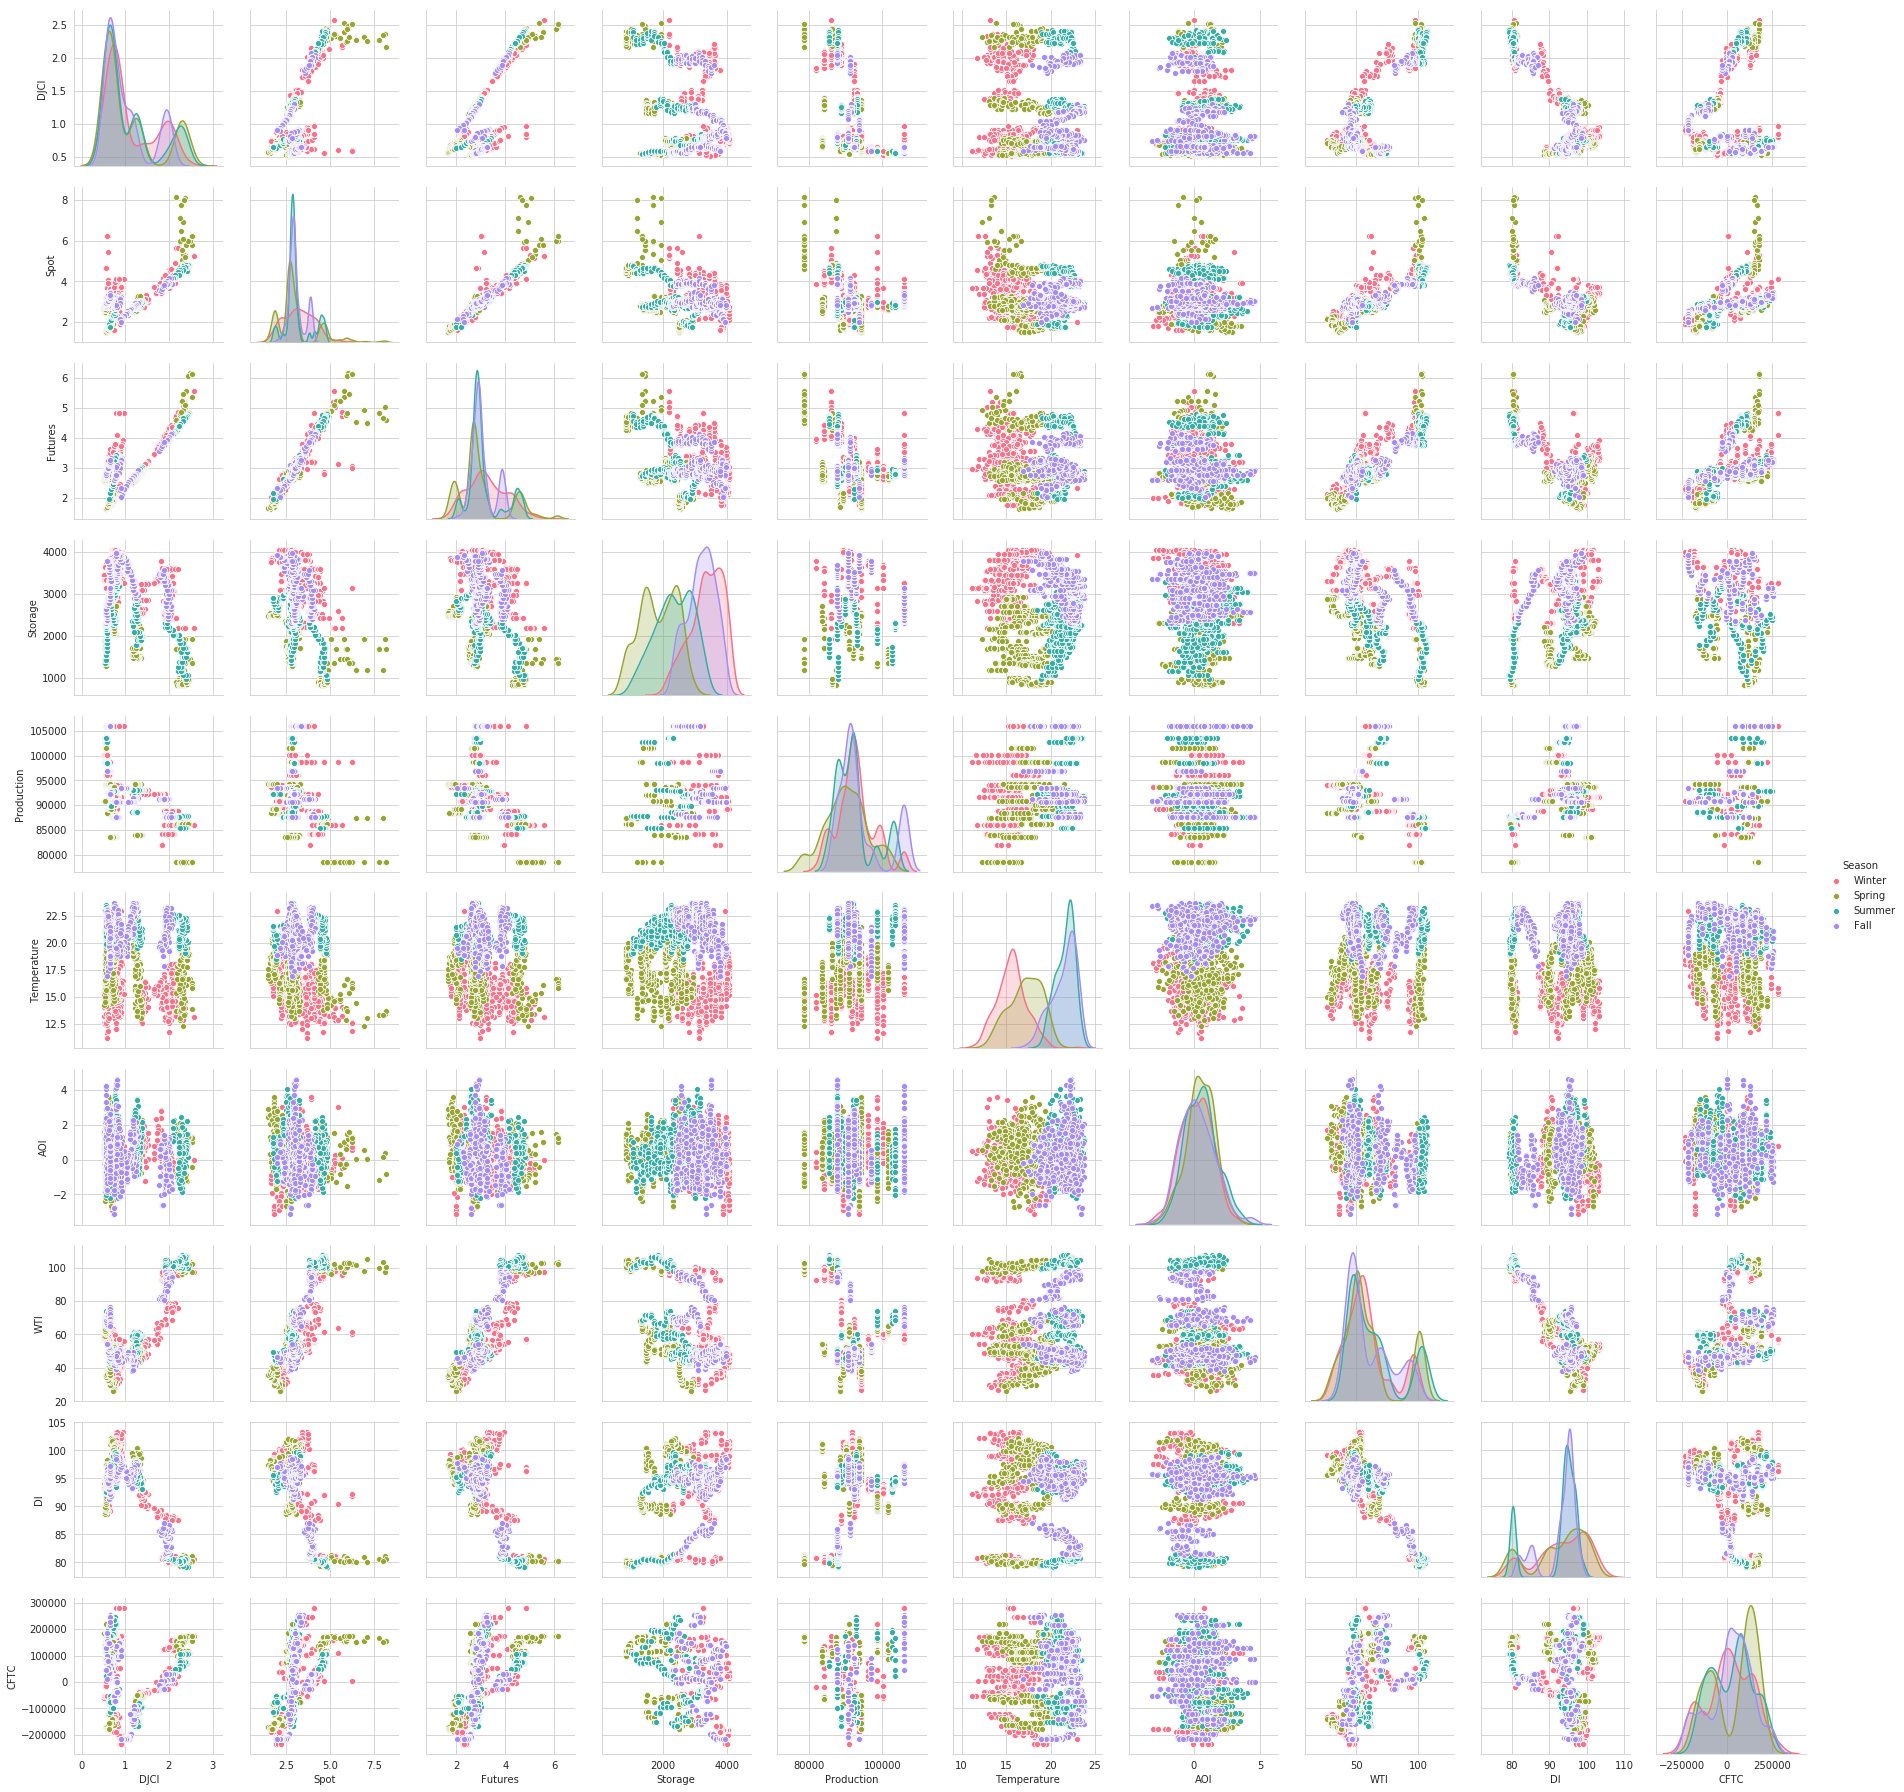

In [21]:
m2season = {  2 : 'Spring' , 5 : 'Summer' ,  8 : 'Fall' , 11 : 'Winter' ,
              3 : 'Spring' , 6 : 'Summer' ,  9 : 'Fall' , 12 : 'Winter' ,
              4 : 'Spring' , 7 : 'Summer' , 10 : 'Fall' ,  1 : 'Winter' }

M['Season'] = M.index.map(lambda x : m2season[x.month])

sns.pairplot(M, hue='Season', palette='husl')


In [22]:
M.corr()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
DJCI,1.000000,0.758383,0.797751,-0.301613,-0.605301,-0.103899,-0.096499,0.767111,-0.792631,-0.003863
Spot,0.758383,1.000000,0.944740,-0.320256,-0.342075,-0.187654,-0.124483,0.819619,-0.730256,0.499694
Futures,0.797751,0.944740,1.000000,-0.291441,-0.362506,-0.140197,-0.159480,0.845422,-0.740016,0.527967
Storage,-0.301613,-0.320256,-0.291441,1.000000,0.041983,-0.007805,-0.030113,-0.470509,0.399718,-0.303042
Production,-0.605301,-0.342075,-0.362506,0.041983,1.000000,0.132875,0.018861,-0.216482,0.354905,0.198826
Temperature,-0.103899,-0.187654,-0.140197,-0.007805,0.132875,1.000000,0.041976,-0.017813,0.055881,-0.085589
AOI,-0.096499,-0.124483,-0.159480,-0.030113,0.018861,0.041976,1.000000,-0.175875,0.084647,-0.153016
WTI,0.767111,0.819619,0.845422,-0.470509,-0.216482,-0.017813,-0.175875,1.000000,-0.881750,0.422311
DI,-0.792631,-0.730256,-0.740016,0.399718,0.354905,0.055881,0.084647,-0.881750,1.000000,-0.212973
CFTC,-0.003863,0.499694,0.527967,-0.303042,0.198826,-0.085589,-0.153016,0.422311,-0.212973,1.000000


In [0]:
M.drop(columns=['Season'], inplace = True)

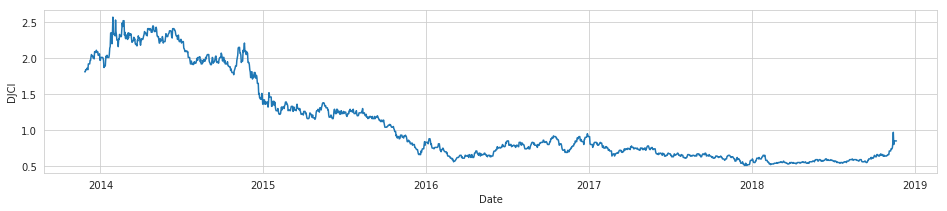

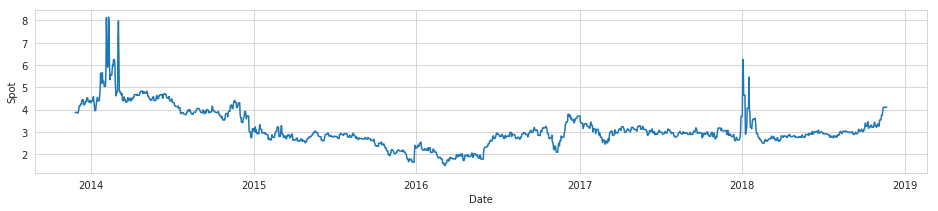

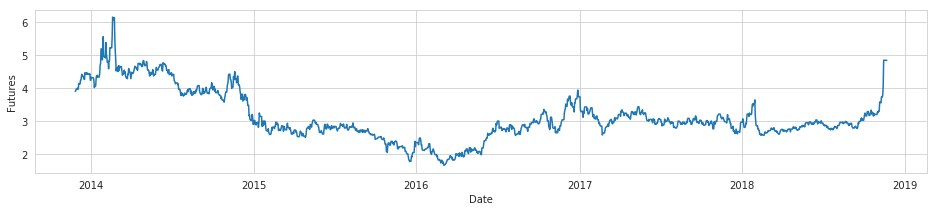

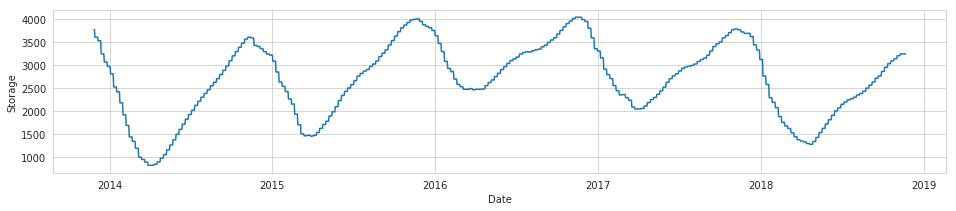

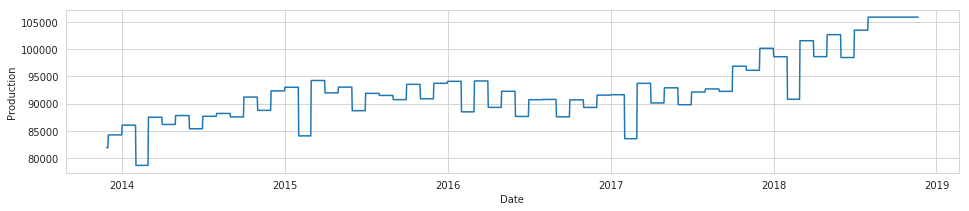

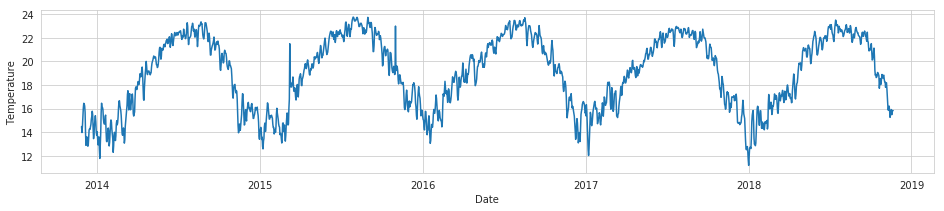

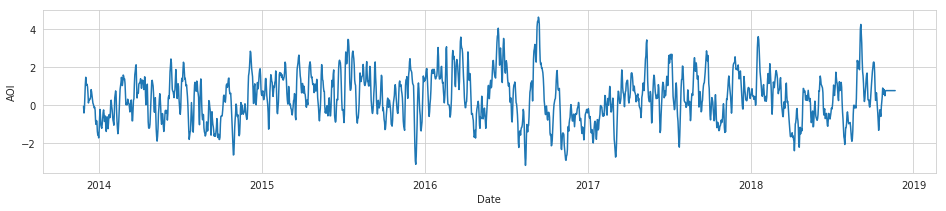

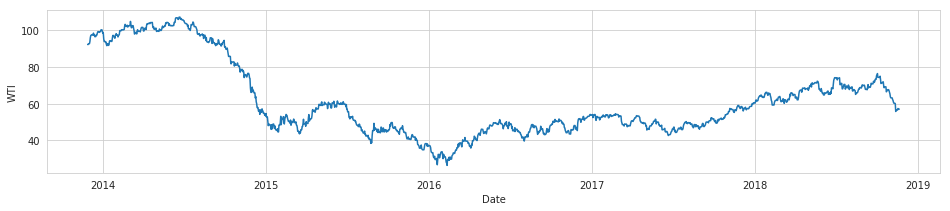

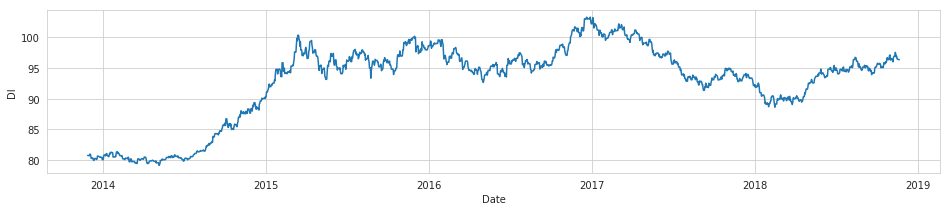

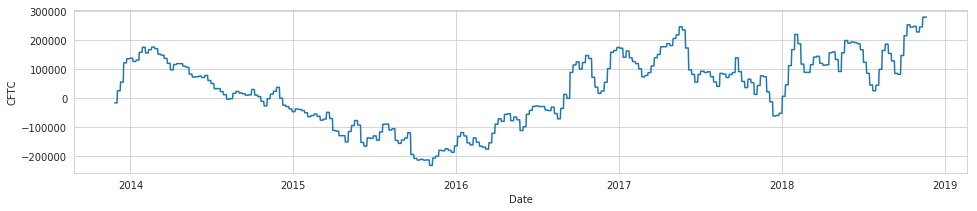

In [46]:
for i in range(len(M.columns)):
  plt.subplots(figsize = (16,3))
  sns.lineplot(x = M.index, y = M.columns[i], data = M)
  plt.show()

## 데이터 정규화

In [26]:
N = M.dropna().apply(scale, axis = 'index', raw = True)
N.head(5)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
Date,,,,,,,,,,
2013-11-27,1.234889,0.891559,1.044944,1.351331,-1.820233,-1.496245,-0.373158,1.543032,-1.918932,-0.372657
2013-11-28,1.234889,0.891559,1.044944,1.351331,-1.820233,-1.663905,-0.659500,1.542041,-1.918932,-0.372657
2013-11-29,1.285958,0.891559,1.123610,1.149996,-1.820233,-1.492957,-0.465050,1.563828,-1.925252,-0.372657
2013-11-30,1.285958,0.891559,1.123610,1.149996,-1.820233,-1.252972,0.037894,1.563828,-1.925252,-0.372657
2013-12-01,1.285958,0.891559,1.123610,1.149996,-1.412943,-0.983401,0.560529,1.563828,-1.925252,-0.372657


In [27]:
N.describe()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
count,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1821.000000,1.821000e+03,1.821000e+03,1.821000e+03
mean,-3.121550e-16,-1.560775e-16,-2.809395e-16,-1.560775e-16,3.340058e-15,-1.794891e-16,0.000000,2.653317e-16,-7.179564e-16,-6.243099e-17
std,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275,1.000275e+00,1.000275e+00,1.000275e+00
min,-9.781121e-01,-1.956591e+00,-1.963054e+00,-2.316211e+00,-2.385112e+00,-2.581107e+00,-2.917416,-1.729352e+00,-2.176471e+00,-2.165097e+00
25%,-7.568120e-01,-4.966147e-01,-5.430550e-01,-6.582981e-01,-6.409619e-01,-8.782018e-01,-0.696421,-6.959935e-01,-4.447933e-01,-7.557357e-01
50%,-5.014658e-01,-2.333404e-01,-2.497219e-01,9.857538e-02,-1.316849e-01,1.441988e-01,-0.020359,-3.830647e-01,2.993858e-01,1.349747e-01
75%,4.007576e-01,3.769774e-01,3.729442e-01,7.746659e-01,2.964425e-01,9.430520e-01,0.656524,3.952961e-01,6.501454e-01,7.854423e-01
max,2.528643e+00,6.013442e+00,4.050274e+00,1.689377e+00,2.342957e+00,1.557807e+00,3.470714,2.283762e+00,1.648704e+00,2.089188e+00


## ARIMA : Facebook Prophet

In [28]:
N1 = N.reset_index()
N1.rename(columns={'Date':'ds', 'DJCI' :'y'}, inplace=True)

N1.dropna(inplace=True)
N1.head(5)

,ds,y,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
0,2013-11-27,1.234889,0.891559,1.044944,1.351331,-1.820233,-1.496245,-0.373158,1.543032,-1.918932,-0.372657
1,2013-11-28,1.234889,0.891559,1.044944,1.351331,-1.820233,-1.663905,-0.659500,1.542041,-1.918932,-0.372657
2,2013-11-29,1.285958,0.891559,1.123610,1.149996,-1.820233,-1.492957,-0.465050,1.563828,-1.925252,-0.372657
3,2013-11-30,1.285958,0.891559,1.123610,1.149996,-1.820233,-1.252972,0.037894,1.563828,-1.925252,-0.372657
4,2013-12-01,1.285958,0.891559,1.123610,1.149996,-1.412943,-0.983401,0.560529,1.563828,-1.925252,-0.372657


In [29]:
fb1 = Prophet(daily_seasonality = True, changepoint_prior_scale = 0.5, yearly_seasonality = 20)
fb1.fit(N1)

In [30]:
future1 = fb1.make_future_dataframe(periods = 60)
future1.tail()

,ds
1876,2019-01-16
1877,2019-01-17
1878,2019-01-18
1879,2019-01-19
1880,2019-01-20


In [31]:
forecast1 = fb1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1876,2019-01-16,-0.603656,-0.782375,-0.409505
1877,2019-01-17,-0.599566,-0.784446,-0.407290
1878,2019-01-18,-0.592255,-0.783575,-0.389209
1879,2019-01-19,-0.581763,-0.780584,-0.380734
1880,2019-01-20,-0.570420,-0.772850,-0.355158


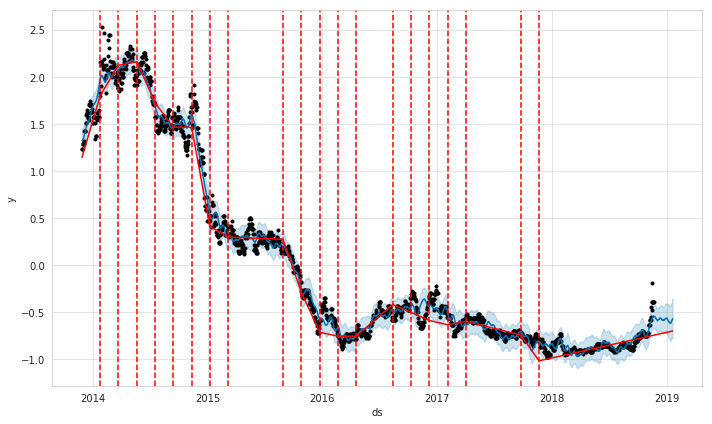

In [32]:
fig1 = fb1.plot(forecast1)
_ = add_changepoints_to_plot(fig1.gca(), fb1, forecast1)

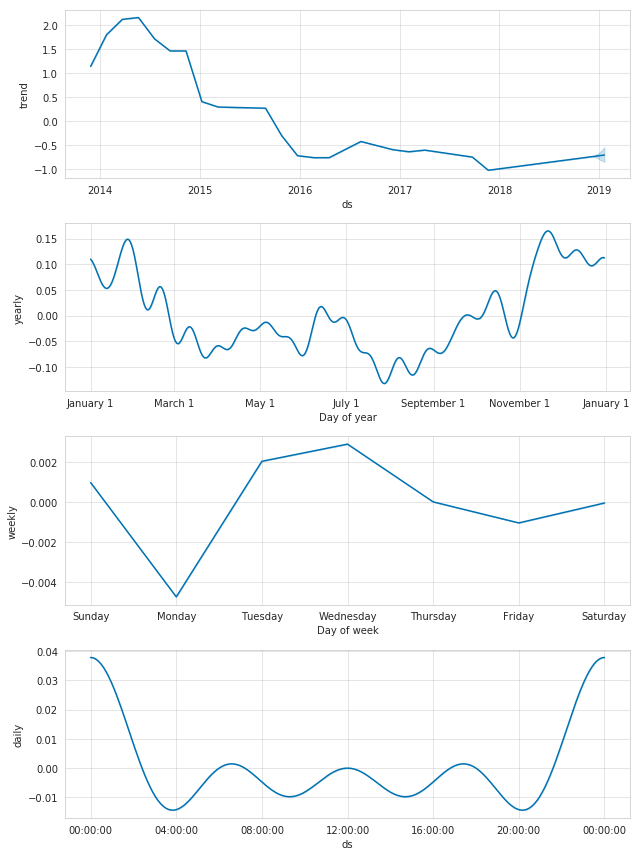

In [33]:
_ = fb1.plot_components(forecast1)

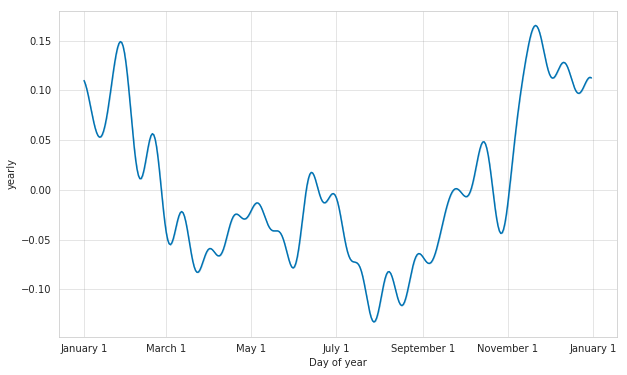

In [34]:
_ = plot_yearly(fb1)

In [35]:
df_cv1 = cross_validation(fb1, initial='730 days', period='60 days', horizon = '365 days')
df_cv1.head()

INFO:fbprophet.diagnostics:Making 13 forecasts with cutoffs between 2015-12-02 00:00:00 and 2017-11-21 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-12-03,-0.700157,-0.805805,-0.598859,-0.484443,2015-12-02
1,2015-12-04,-0.744463,-0.844943,-0.649110,-0.484443,2015-12-02
2,2015-12-05,-0.776739,-0.882976,-0.676417,-0.484443,2015-12-02
3,2015-12-06,-0.802942,-0.905647,-0.706371,-0.484443,2015-12-02
4,2015-12-07,-0.838652,-0.943587,-0.734515,-0.552535,2015-12-02


In [36]:
df_p1 = performance_metrics(df_cv1)
df_p1.head()

,horizon,mse,rmse,mae,mape,coverage
766,37 days,0.100790,0.317474,0.207683,0.431094,0.529536
1496,37 days,0.100739,0.317394,0.207545,0.430788,0.531646
1861,37 days,0.100786,0.317468,0.207676,0.430783,0.533755
2956,37 days,0.100791,0.317476,0.207714,0.430846,0.533755
4051,37 days,0.100820,0.317522,0.207948,0.431115,0.533755


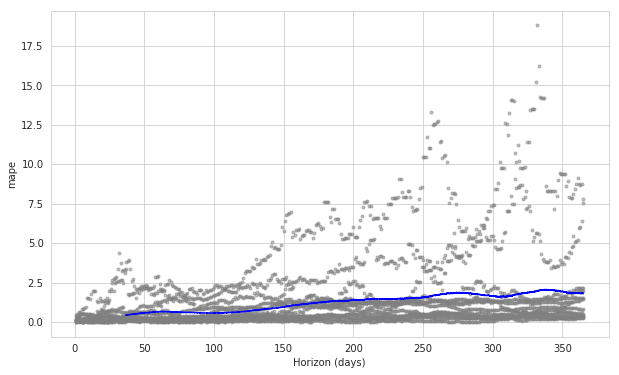

In [37]:
_ = plot_cross_validation_metric(df_cv1, metric='mape')

## Deep Learning : Keras

In [0]:
look_back = 1

def create_dataset(dataset, look_back = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - look_back - 1):
    a = dataset[i:(i + look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back])
  return np.array(dataX), np.array(dataY)

In [0]:
scaler = MinMaxScaler(feature_range = (0, 1))

N2 = scaler.fit_transform(M.astype(np.float))

In [0]:
# split train, test
train_size = int(len(N2) * 0.9)
test_size  = len(N2) - train_size
train, test = N2[0:train_size], N2[train_size:len(N2)]

In [0]:
# create dataset for learning
trainX, trainY = create_dataset(train)
testX , testY  = create_dataset(test)

In [0]:
# reshape input to be [samples, time steps, features]
n_features = testX.shape[2]
trainX = np.reshape(trainX, (trainX.shape[0], 1, n_features))
testX  = np.reshape(testX , (testX.shape[0] , 1, n_features))

In [43]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(8, input_shape = (look_back, n_features)))
model.add(Dense(units = 10))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 10, batch_size = 1)

Epoch 1/10
1636/1636 [==============================] - 4s 2ms/step - loss: 0.0412
Epoch 2/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 3/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0042
Epoch 4/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0022
Epoch 5/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 6/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 7/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 8/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 9/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 10/10
1636/1636 [==============================] - 3s 2ms/step - loss: 0.0013


In [44]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 5405.02 RMSE


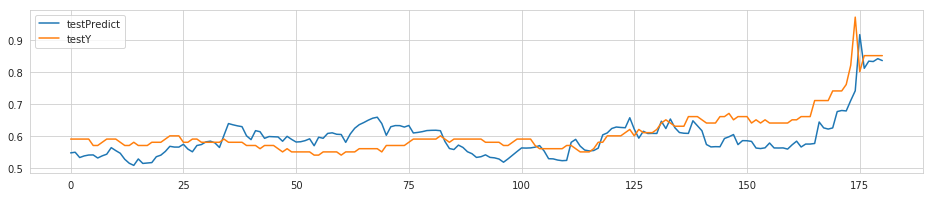

In [47]:
data = {
    'testPredict' : testPredict[:, 0],
    'testY'       : testY[:, 0],
}

df_plot = pd.DataFrame(data)
df_plot.plot(figsize = (16,3))